# Interconnectors

This tutorial covers GB interconnectors to neighboring countries - analyzing cross-border electricity flows and their role in system balancing.

## What You'll Learn

- Interconnector capacity and connections
- Import/export flow patterns
- Price-driven flows
- Interconnector utilization
- Value of interconnection

## 1. Setup

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
from pyproj import Transformer

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

colors = {
    'France': '#0055A4', 'Belgium': '#FFCD00', 'Netherlands': '#FF6600',
    'Norway': '#BA0C2F', 'Ireland': '#169B62', 'Denmark': '#C8102E',
    'import': '#E91E63', 'export': '#4CAF50'
}

print(f"PyPSA version: {pypsa.__version__}")

PyPSA version: 1.0.7


## 2. Load Network

In [2]:
# Load a network with interconnectors
n = pypsa.Network("../../../resources/network/HT35_clustered_solved.nc")

print(f"Network loaded")
print(f"  Snapshots: {len(n.snapshots)}")
print(f"  Links: {len(n.links)}")

INFO:pypsa.network.io:Imported network 'HT35_clustered (Clustered)' has buses, carriers, generators, lines, links, loads, storage_units, stores, sub_networks


Network loaded
  Snapshots: 168
  Links: 282


## 3. Interconnector Overview

GB is connected to continental Europe and Ireland via HVDC links.

In [3]:
# Identify interconnectors (links connecting to external markets)
# Look for links with specific carrier types or naming patterns
links = n.links.copy()

print(f"Total links: {len(links)}")
print(f"\nLink carriers:")
print(links['carrier'].value_counts())

Total links: 282

Link carriers:
carrier
H2_turbine      242
electrolysis     24
DC               13
AC                3
Name: count, dtype: int64


In [4]:
# Filter interconnectors (adjust based on your network's naming convention)
interconnector_keywords = ['IFA', 'BritNed', 'NEMO', 'NSL', 'Moyle', 'EWIC', 'VikingLink', 'interconnector', 'IC']

# Try to identify interconnectors by name or carrier
mask = links.index.str.contains('|'.join(interconnector_keywords), case=False, na=False)
if not mask.any():
    # Try carrier
    mask = links['carrier'].str.contains('interconnector|HVDC|DC', case=False, na=False)

if mask.any():
    interconnectors = links[mask]
    print(f"Found {len(interconnectors)} interconnectors:")
    print(interconnectors[['bus0', 'bus1', 'p_nom', 'carrier']].to_string())
else:
    print("No interconnectors found - using all links for demonstration")
    interconnectors = links.head(5)  # Use first 5 links as example

Found 13 interconnectors:
                                                   bus0                                                      bus1        p_nom carrier
name                                                                                                                                  
IC_Britned                                         NFLE             External_HVDC_External_Netherlands_Maasvlakte  1928.093918      DC
IC_IFA                                           SELL_1                      External_HVDC_External_France_Calais  3833.050709      DC
IC_IFA2                                          BOTW_1                      External_HVDC_External_France_Calais  1928.093918      DC
IC_Nemo Link                               RICH_J|RICH1                  External_HVDC_External_Belgium_Zeebrugge  1966.655797      DC
IC_NS Link                                       BLYTB1                    External_HVDC_External_Norway_Kvilldal  2699.331485      DC
IC_Moyle                     

## 4. Interconnector Capacity

In [5]:
# Capacity summary
if len(interconnectors) > 0:
    total_import_capacity = interconnectors['p_nom'].sum() / 1000  # GW
    print(f"Total Import Capacity: {total_import_capacity:.2f} GW")
    
    # Capacity by interconnector
    print("\nCapacity by Interconnector (MW):")
    for ic in interconnectors.index:
        print(f"  {ic}: {interconnectors.loc[ic, 'p_nom']:.0f} MW")

Total Import Capacity: 23.65 GW

Capacity by Interconnector (MW):
  IC_Britned: 1928 MW
  IC_IFA: 3833 MW
  IC_IFA2: 1928 MW
  IC_Nemo Link: 1967 MW
  IC_NS Link: 2699 MW
  IC_Moyle: 916 MW
  IC_ElecLink: 1928 MW
  IC_Viking: 2699 MW
  IC_Auchencrosh (interconnector CCT): 964 MW
  IC_East West Interconnector: 974 MW
  IC_Greenlink: 972 MW
  IC_Isle of Man Interconnector: 143 MW
  IC_NeuConnect Interconnector: 2699 MW


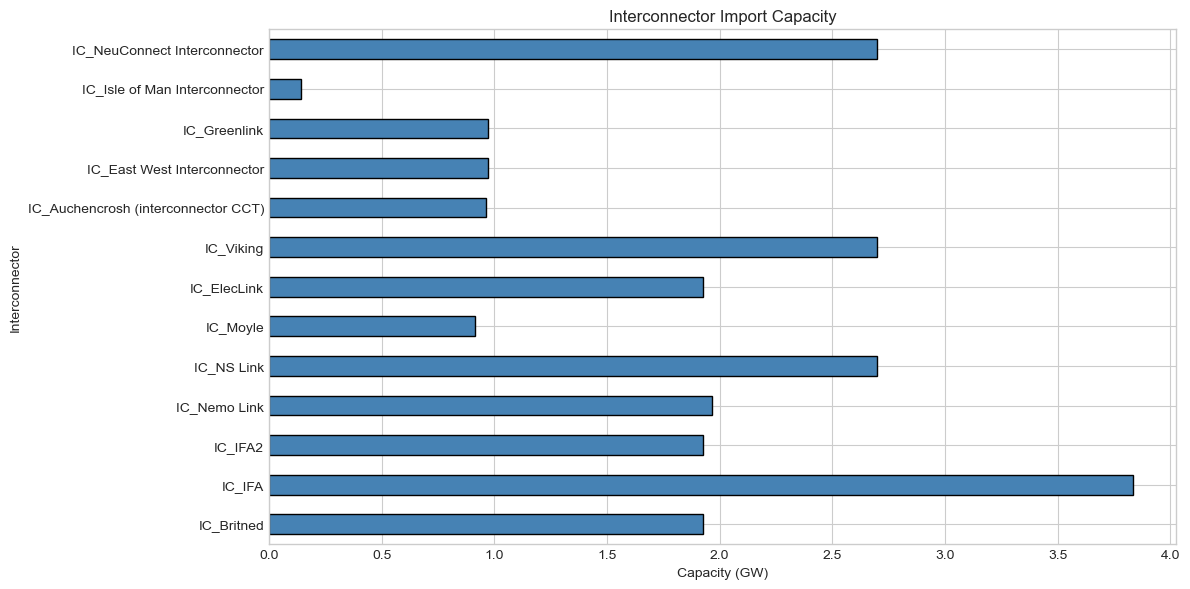

In [6]:
# Capacity bar chart
if len(interconnectors) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    capacity = interconnectors['p_nom'] / 1000  # GW
    capacity.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
    
    ax.set_xlabel('Capacity (GW)')
    ax.set_ylabel('Interconnector')
    ax.set_title('Interconnector Import Capacity')
    
    plt.tight_layout()
    plt.show()

## 5. Power Flows

In [7]:
# Get flow data
if len(n.links_t.p0.columns) > 0:
    flows = n.links_t.p0
    
    # Filter to interconnectors
    ic_flows = flows[[c for c in interconnectors.index if c in flows.columns]]
    
    if len(ic_flows.columns) > 0:
        print("Flow Statistics (MW):")
        print("  Positive = flow from bus0 to bus1")
        print(ic_flows.describe().round(0))
    else:
        print("No interconnector flow data available")
        ic_flows = None
else:
    print("No link flow data")
    ic_flows = None

Flow Statistics (MW):
  Positive = flow from bus0 to bus1
name   IC_Britned  IC_IFA  IC_IFA2  IC_Nemo Link  IC_NS Link  IC_Moyle  \
count       168.0   168.0    168.0         168.0       168.0     168.0   
mean       -224.0  -354.0  -1781.0        -211.0     -1210.0      -7.0   
std         438.0  2407.0    381.0         610.0      1285.0       6.0   
min       -1714.0 -3833.0  -1928.0       -1967.0     -2699.0     -86.0   
25%         -79.0 -3833.0  -1928.0          -0.0     -2699.0      -7.0   
50%         -77.0  1292.0  -1924.0          -0.0        -1.0      -7.0   
75%         -72.0  1548.0  -1851.0          -0.0        -0.0      -7.0   
max          81.0  1622.0   1899.0          -0.0        -0.0      -6.0   

name   IC_ElecLink  IC_Viking  IC_Auchencrosh (interconnector CCT)  \
count        168.0      168.0                                168.0   
mean        -398.0      -72.0                                  6.0   
std         1012.0      415.0                                  7.

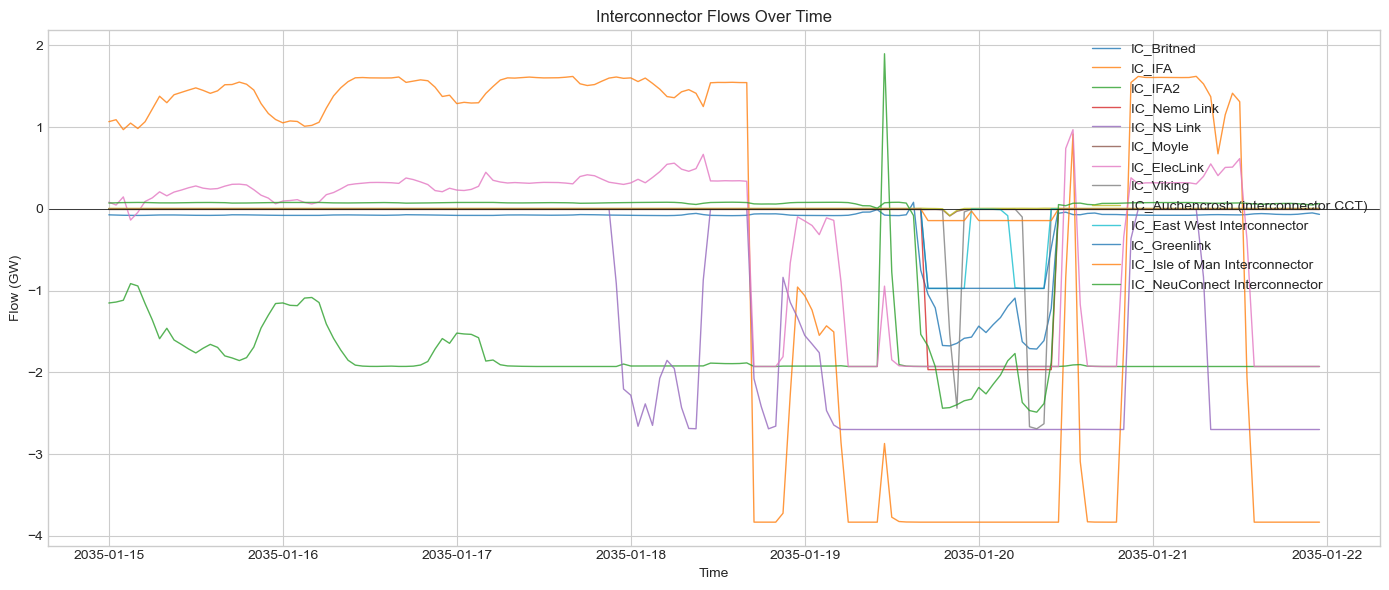

In [8]:
# Flow time series
if ic_flows is not None and len(ic_flows.columns) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for col in ic_flows.columns:
        ax.plot(ic_flows.index, ic_flows[col] / 1000, linewidth=1, label=col, alpha=0.8)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_ylabel('Flow (GW)')
    ax.set_xlabel('Time')
    ax.set_title('Interconnector Flows Over Time')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

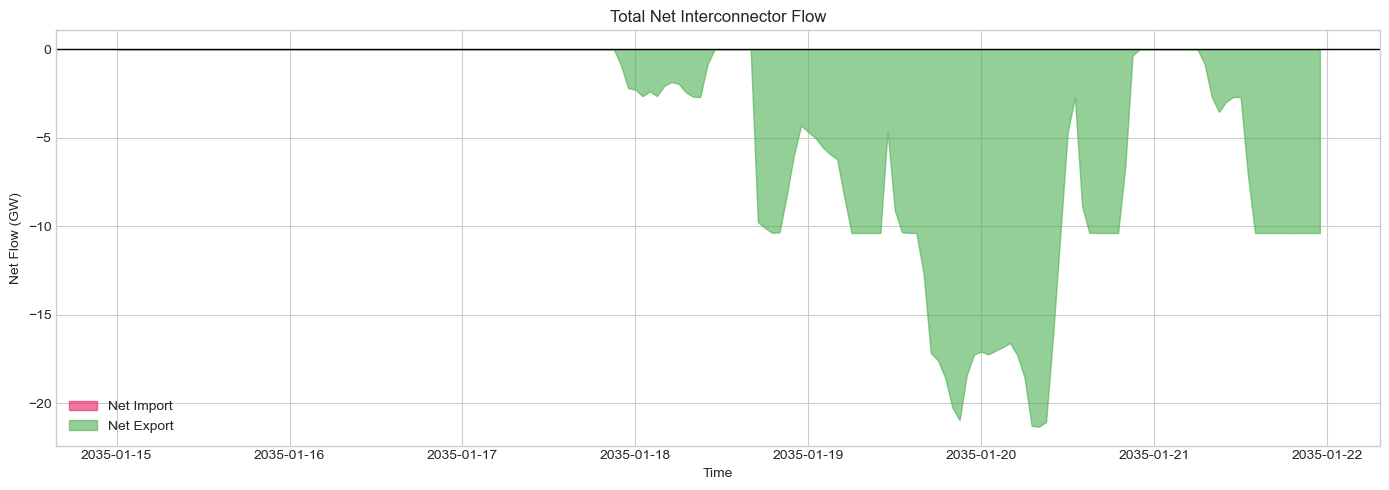

Net Import Statistics:
  Total Import: 0.0 GWh
  Total Export: 774.7 GWh
  Net: -774.7 GWh


In [9]:
# Total net import/export
if ic_flows is not None and len(ic_flows.columns) > 0:
    total_flow = ic_flows.sum(axis=1) / 1000  # GW
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    ax.fill_between(total_flow.index, total_flow, 
                   where=total_flow >= 0, alpha=0.6, color=colors['import'], label='Net Import')
    ax.fill_between(total_flow.index, total_flow, 
                   where=total_flow < 0, alpha=0.6, color=colors['export'], label='Net Export')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    ax.set_ylabel('Net Flow (GW)')
    ax.set_xlabel('Time')
    ax.set_title('Total Net Interconnector Flow')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"Net Import Statistics:")
    print(f"  Total Import: {total_flow[total_flow > 0].sum():.1f} GWh")
    print(f"  Total Export: {-total_flow[total_flow < 0].sum():.1f} GWh")
    print(f"  Net: {total_flow.sum():.1f} GWh")

## 6. Interconnector Utilization

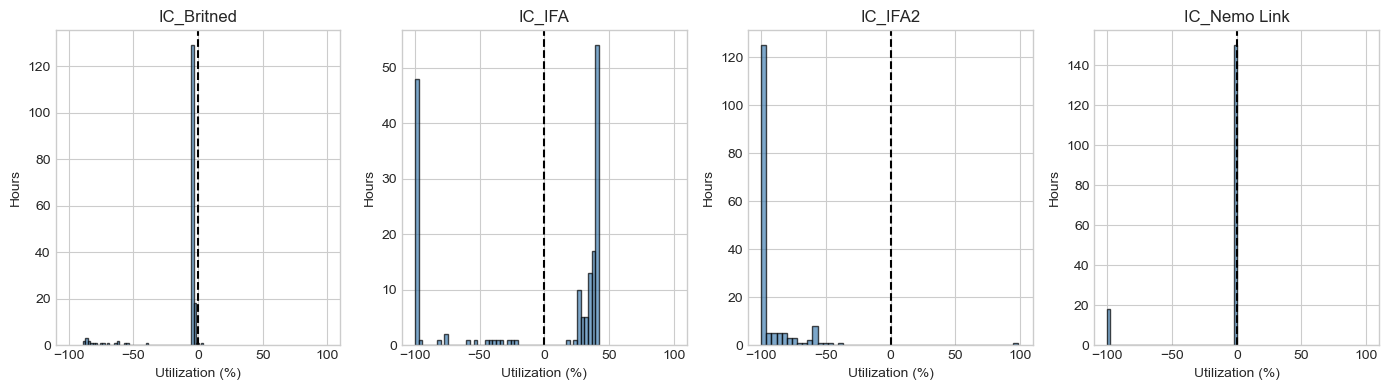

In [11]:
# Utilization histogram
if ic_flows is not None and len(ic_flows.columns) > 0:
    fig, axes = plt.subplots(1, min(len(ic_flows.columns), 4), figsize=(14, 4))
    if len(ic_flows.columns) == 1:
        axes = [axes]
    
    for idx, ic in enumerate(ic_flows.columns[:4]):
        if ic in interconnectors.index:
            ax = axes[idx]
            p_nom = interconnectors.loc[ic, 'p_nom']
            util = ic_flows[ic] / p_nom * 100
            
            ax.hist(util, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
            ax.axvline(x=0, color='black', linestyle='--')
            ax.set_xlabel('Utilization (%)')
            ax.set_ylabel('Hours')
            ax.set_title(ic[:20])  # Truncate long names
            ax.set_xlim(-110, 110)
    
    plt.tight_layout()
    plt.show()

## 7. Daily Import/Export Patterns

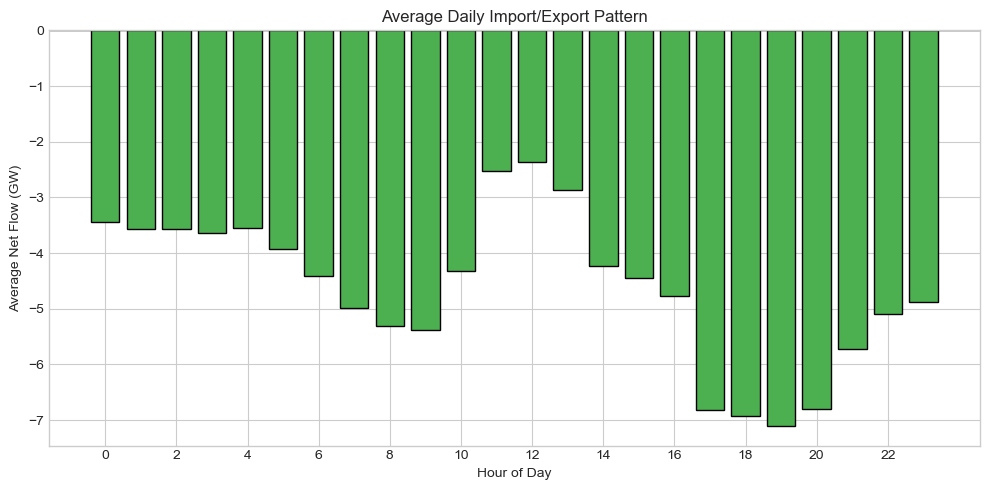

In [12]:
# Average daily pattern
if ic_flows is not None and len(ic_flows.columns) > 0:
    total_flow = ic_flows.sum(axis=1) / 1000  # GW
    hourly_avg = total_flow.groupby(total_flow.index.hour).mean()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    bars = ax.bar(hourly_avg.index, hourly_avg, 
                 color=[colors['import'] if v > 0 else colors['export'] for v in hourly_avg],
                 edgecolor='black')
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Net Flow (GW)')
    ax.set_title('Average Daily Import/Export Pattern')
    ax.set_xticks(range(0, 24, 2))
    
    plt.tight_layout()
    plt.show()

## 8. Price-Driven Flows

Correlation: -0.944


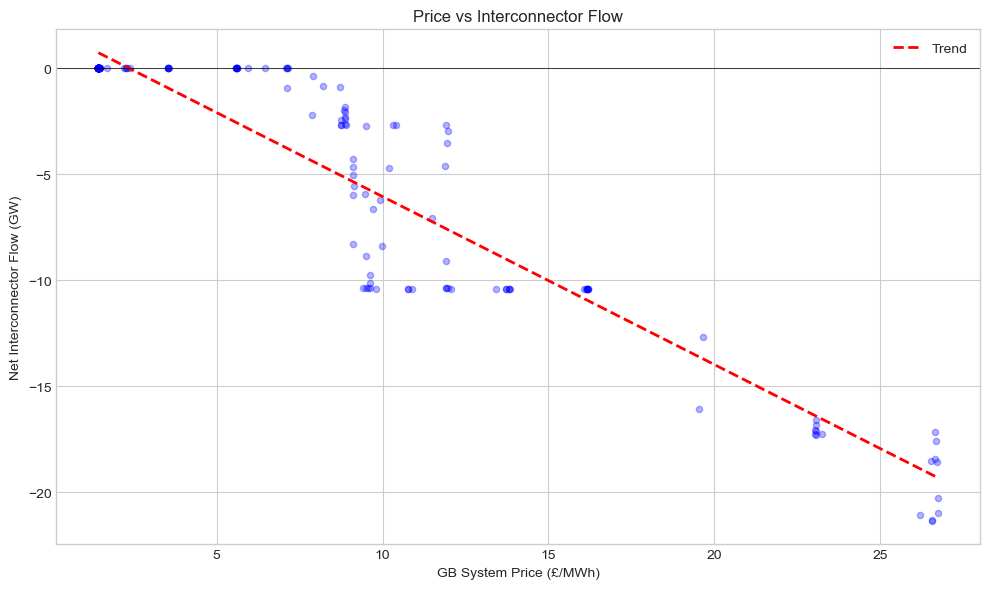

In [13]:
# Analyze relationship between prices and flows
if 'marginal_price' in n.buses_t and ic_flows is not None:
    lmps = n.buses_t.marginal_price
    
    # System average price
    system_price = lmps.mean(axis=1)
    total_flow = ic_flows.sum(axis=1) / 1000
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    scatter = ax.scatter(system_price, total_flow, alpha=0.3, s=20, c='blue')
    
    # Trend line
    z = np.polyfit(system_price, total_flow, 1)
    p = np.poly1d(z)
    x_sorted = system_price.sort_values()
    ax.plot(x_sorted, p(x_sorted), 'r--', linewidth=2, label='Trend')
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('GB System Price (£/MWh)')
    ax.set_ylabel('Net Interconnector Flow (GW)')
    ax.set_title('Price vs Interconnector Flow')
    ax.legend()
    
    corr = system_price.corr(total_flow)
    print(f"Correlation: {corr:.3f}")
    
    plt.tight_layout()
    plt.show()

## 9. Interconnector Value

In [14]:
# Calculate value of interconnector flows
if 'marginal_price' in n.buses_t and ic_flows is not None:
    value = []
    
    for ic in ic_flows.columns:
        if ic in interconnectors.index:
            bus0 = interconnectors.loc[ic, 'bus0']
            bus1 = interconnectors.loc[ic, 'bus1']
            
            flow = ic_flows[ic]  # Positive = bus0 → bus1
            
            # Value based on price at receiving end
            if bus0 in lmps.columns and bus1 in lmps.columns:
                price0 = lmps[bus0]
                price1 = lmps[bus1]
                
                # Congestion rent = flow × (price_receiving - price_sending)
                # When flow > 0: sending from bus0, receiving at bus1
                # When flow < 0: sending from bus1, receiving at bus0
                cong_rent = flow.abs() * (price1 - price0).abs()
                
                value.append({
                    'Interconnector': ic,
                    'Congestion Rent (£M)': cong_rent.sum() / 1e6,
                    'Avg Price Spread (£/MWh)': (price1 - price0).abs().mean()
                })
    
    if value:
        value_df = pd.DataFrame(value).set_index('Interconnector')
        print("Interconnector Value:")
        print(value_df.round(2))

Interconnector Value:
                                     Congestion Rent (£M)  \
Interconnector                                              
IC_Britned                                           0.02   
IC_IFA                                               1.40   
IC_IFA2                                              1.34   
IC_Nemo Link                                         0.08   
IC_NS Link                                           1.42   
IC_Moyle                                             0.00   
IC_ElecLink                                          0.70   
IC_Viking                                            0.01   
IC_Auchencrosh (interconnector CCT)                  0.00   
IC_East West Interconnector                          0.04   
IC_Greenlink                                         0.11   
IC_Isle of Man Interconnector                        0.01   
IC_NeuConnect Interconnector                         0.03   

                                     Avg Price Spread (£/MWh) 

## 10. Flow Duration Curves

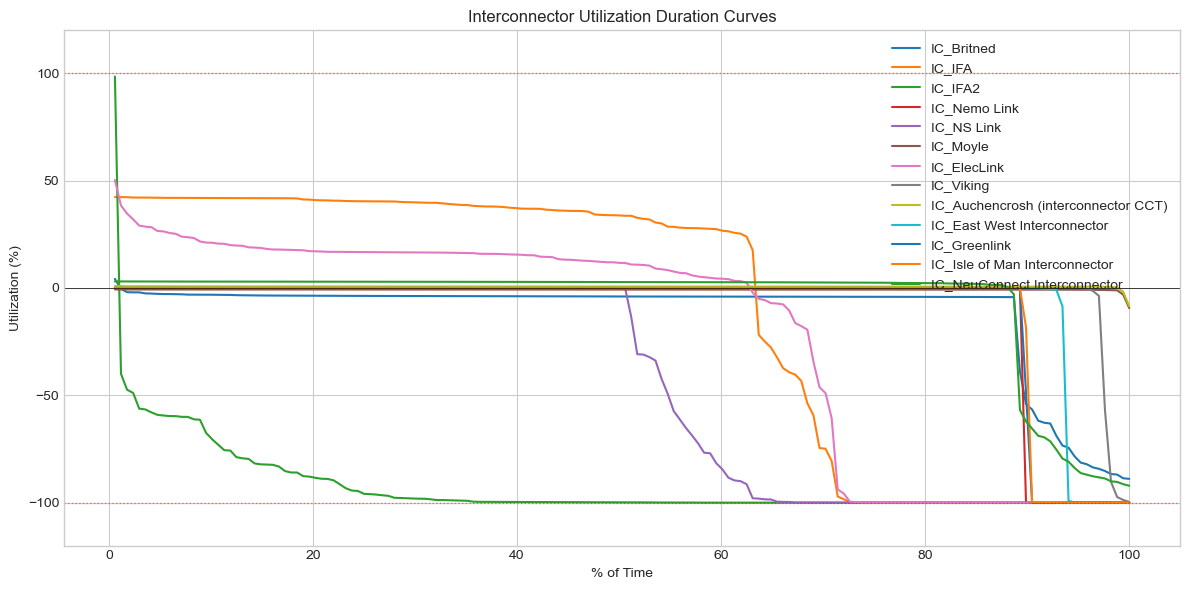

In [15]:
# Flow duration curves
if ic_flows is not None and len(ic_flows.columns) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for ic in ic_flows.columns:
        if ic in interconnectors.index:
            p_nom = interconnectors.loc[ic, 'p_nom']
            util = (ic_flows[ic] / p_nom * 100).sort_values(ascending=False).values
            hours = np.arange(1, len(util) + 1) / len(util) * 100
            ax.plot(hours, util, linewidth=1.5, label=ic)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.axhline(y=100, color='red', linestyle=':', linewidth=1, alpha=0.5)
    ax.axhline(y=-100, color='red', linestyle=':', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('% of Time')
    ax.set_ylabel('Utilization (%)')
    ax.set_title('Interconnector Utilization Duration Curves')
    ax.legend()
    ax.set_ylim(-120, 120)
    
    plt.tight_layout()
    plt.show()